In [268]:
using Luxor

In [186]:
grid = zeros(Float64,10,10)

grid[8,9] = 10
grid[3,8] = 3
grid[5,4] = -5
grid[8,4] = -10
grid

values = copy(grid)

10×10 Array{Float64,2}:
 0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0
 0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0
 0.0  0.0  0.0    0.0  0.0  0.0  0.0  3.0   0.0  0.0
 0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0
 0.0  0.0  0.0   -5.0  0.0  0.0  0.0  0.0   0.0  0.0
 0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0
 0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0
 0.0  0.0  0.0  -10.0  0.0  0.0  0.0  0.0  10.0  0.0
 0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0
 0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0   0.0  0.0

In [311]:
function draw_grid(grid)
    Drawing(400,400)
    background("black")
    
    grid = transpose(grid)
    
    tiles = Tiler(400, 400, 10, 10, margin=5)
    grid_max = max(grid...)
    grid_min = min(grid...)
    
    for (pos, n) in tiles
        box(pos+Point(200,200), tiles.tilewidth*0.95, tiles.tileheight*0.95, :clip)
        if grid[n] > 0
            hue = (grid[n]/max(grid...))
            intensity = (1 - hue)/2
            if(intensity == 0) 
                background(1,1,1)
            else
                background(0,intensity,0)
            end
        elseif grid[n] < 0
            hue = (grid[n]/min(grid...))
            intensity = (1 - hue)/2
            if(intensity == 0) 
                background(1,1,1)
            else
                background(intensity,0,0)
            end
        else
            background("white")
        end
        sethue("black")
        textcentred(string(round(grid[n], digits=2)), pos+Point(200,200))
        clipreset()
    end
    finish()
    preview()
end

draw_grid (generic function with 2 methods)

In [326]:
function draw_grid(grid)
    Drawing(400,400)
    background("black")
    
    grid = transpose(grid)
    
    tiles = Tiler(400, 400, 10, 10, margin=5)
    g = [:red, :white, :green]
    colors = cgrad(g)
    grid_max = max(grid...)
    grid_min = min(grid...)
    for (pos, n) in tiles
        box(pos+Point(200,200), tiles.tilewidth*0.95, tiles.tileheight*0.95, :clip)
        intensity = (grid[n]-grid_min)/(grid_max-grid_min)
        background(colors[intensity])
        
        sethue("black")
        textcentred(string(round(grid[n], digits=2)), pos+Point(200,200))
        clipreset()
    end
    finish()
    preview()
end

draw_grid (generic function with 2 methods)

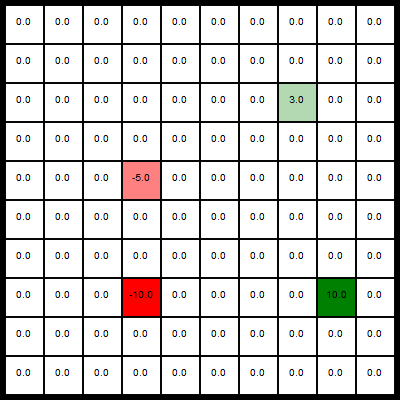

In [327]:
draw_grid(grid)

# Policy Evaluation

In [65]:
# Create very simple policy
p = ["" for i in 1:10, j in 1:10]

for i in 1:10
    for j in 1:10
        if i < pos_reward_position[1]
            p[i,j] = "D"
        elseif i > pos_reward_position[1]
            p[i,j] = "U"
        elseif j > pos_reward_position[2]
            p[i,j] = "L"
        elseif j < pos_reward_position[2]
            p[i,j] = "R"
        else
            p[i,j] = ""
        end
    end
end

In [157]:
# How to represent state?

function TransitionProb(s, a, s_prime)
    # s_prime and s must be arrays
    
    diff = s_prime - s
    success_prob = 0.70
    
    if a == "U" && diff==[-1,0]
        return success_prob
    elseif a == "R" && diff==[0,1]
        return success_prob
    elseif a == "D" && diff==[1,0]
        return success_prob
    elseif a == "L" && diff==[0,-1]
        return success_prob
    else
        return (1-success_prob)/3
    end
end


function R(s, a, grid)
    # Given state s and action a, return reward
    
    # Handle Edge bumping 
        # -> -1 reward for edge bump
    r = 0
    if a == "U" && s[2] == 1
        return r -= 1
    elseif a == "R" && s[1] ==10
        return r -= 1
    elseif a == "D" && s[2]== 10
        return r -= 1
    elseif a == "L" && s[1] == 1
        return r -= 1
    end
    
    r += grid[s[1],s[2]]
    
    return r
        
end


function move(s,a)
    # Given some action(a) and state(s), return next state s'
    actions = ["L","R","U","D"]
    filter!(x->x≠a,actions)
    
    prob = rand()
    if prob > 0.7
        action = a
    else
        action = rand(actions)
    end
    
    if action == "L" && s[2] == 1
        return ""
    elseif action == "R" && s[2] == 10
        return ""
    elseif action == "U" && s[1] == 1
        return ""
    elseif action == "D" && s[1] == 10
        return ""
    else
        return action
    end        
end


function next_pos(s,a)
    # Returns next position/state given some action input (deterministic)
        # Used in padded grid, so no edge exceptions need to be made
    if a == "L"# && !(s[2] == 1)
        return s + [0,-1]
    elseif a == "R" #&& !(s[2] == 10)
        return s + [0,1]
    elseif a == "U"# && !(s[1] == 1)
        return s + [-1,0]
    elseif a == "D"# && !(s[1] == 10)
        return s + [1,0]
    else
        return s
    end        
end

next_pos (generic function with 1 method)

# Value Iteration

$$U_{n}(s)=\max _{a}\left(R(s, a)+\sum_{s^{\prime}} T\left(s^{\prime} \mid s, a\right) U_{n-1}\left(s^{\prime}\right)\right)$$

$$U^{*}(s)=\max _{a}\left(R(s, a)+\gamma \sum_{s^{\prime}} T\left(s^{\prime} \mid s, a\right) U^{*}\left(s^{\prime}\right)\right)$$

In [340]:
# How to represent state?
# How to handle box
# Structure

function ValueIteration(grid, n)
    absorb_states = [(8,9),(3,8)] # Excluding (5,4),(8,4)
    
    k = 0
    U_s = copy(grid)
    γ = 0.9
    all_actions = ["U","D","L","R"]
    
    for i in 1:n
        # Create padded grid to handle edge bumping (-1 reward)
        padded_grid = copy(U_s)
        padded_grid = hcat(ones(10)*-1, padded_grid, ones(10)*-1)
        padded_grid = vcat(ones(1,10+2)*-1, padded_grid, ones(1,10+2)*-1)

        # Iterate over all grid positions
        for i in 1:10
            for j in 1:10
                s = [i+1,j+1] # Padded Grid Position
                R = grid[i,j]
                # Iterate over all possible actions to find action that maximizes utility
                sums = []
                for a in all_actions
                    # sum(T*U) for each action
                    prob_sum = sum(TransitionProb(s,a,next_pos(s,act))*padded_grid[next_pos(s,act)[1],next_pos(s,act)[2]] for act in all_actions)
                    push!(sums,prob_sum)
                end
                (i,j) in absorb_states ? U_s[i,j] = R : U_s[i,j] = R + γ*findmax(sums)[1]
            end
        end
    end
        
    return U_s
end

ValueIteration (generic function with 2 methods)

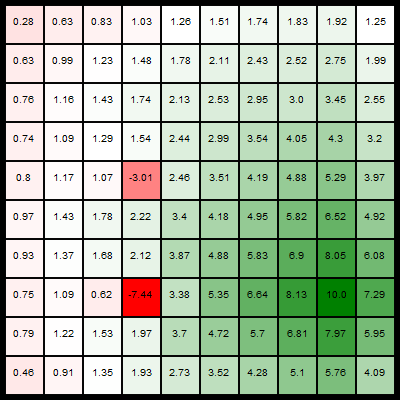

In [344]:
new_grid = ValueIteration(grid,3000);
draw_grid(new_grid)